{{title_its_nb4}}
{{intro}}

The previous notebooks in this tutorial demonstrated how to use Xarray to access, inspect, manipulate and analyze raster time series data at the scale of an individual glacier. In this notebook, we shift our focus to a sub-regional scale, looking at all of the glaciers within a given ITS_LIVE data cube. This workflow will draw on elements from the past notebooks while introducing new tools for examining raster data along temporal and spatial dimensions (ie. across multiple glaciers). 



{{outline}}

(content:Section_A)=
**[A. Read and organize data](#a-read-and-organize-data)**
- {{a1_its_nb4}}
- {{a2_its_nb4}}

(content:Section_B)=
**[B. Combine raster and vector data to create a vector data cube](#b-combine-raster-and-vector-data-to-create-a-vector-data-cube)
- {{b1_its_nb4}}
- {{b2_its_nb4}}
- {{b3_its_nb4}}

(content:Section_C)= 
**[C. Data visualization](#c-data-visualization)**
- {{c1_its_nb4}}
- {{c2_its_nb4}}
- {{c3_its_nb4}}

{{learning_goals}}

{{concepts}}
- Querying and accessing raster data from cloud object storage
- Accessing and manipulating vector data
- Handling coordinate reference information
- Calculating and visualizing summary statistics

{{techniques}}
- Access cloud-hosted [Zarr](https://zarr.readthedocs.io/en/stable/) data cubes using [Xarray](https://xarray.dev/)
- Reading [GeoParquet](https://geoparquet.org/) vector data using [GeoPandas](https://geopandas.org/en/stable/)
- Rasterize vector objects using [Geocube]()
- Spatial joins of vector datasets using [GeoPandas](https://geopandas.org/en/stable/)
- Using [dask](https://www.dask.org/) to work with out-of-memory data
- Calculating summary statistics of [Xarray](https://xarray.dev/) and [Pandas](https://pandas.pydata.org/) objects
- Data visualization using [Pandas](https://pandas.pydata.org/)
- Interactive data visualization with [GeoPandas](https://geopandas.org/en/stable/)

Expand the next cell to see specific packages used in this notebook and relevant system and version information. 

In [1]:
%xmode minimal

import contextily as cx
import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import xvec

import itslivetools
    
%config InlineBackend.figure_format='retina'

Exception reporting mode: Minimal


## A. Read and organize data

### {{a1_its_nb4}}

As in past notebooks, we use `itslivetools.find_granule_by_point()` to query the ITS_LIVE catalog for the correct url.

In [2]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

In [3]:
url = itslivetools.find_granule_by_point([95.180191, 30.645973])
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2-updated-october2024/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

Following the example shown in the initial data inspection [notebook](), we read the data in *without* dask at first so that we can lazily organize the dataset in chronological order

In [4]:
dc = itslivetools.read_in_s3(url, chunks_arg=None)
dc = dc.sortby('mid_date')
dc

<xarray.Dataset> Size: 1TB
Dimensions:                     (mid_date: 47892, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 383kB 1986-09-11T03...
  * x                           (x) float64 7kB 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 7kB 3.4e+06 3.4e+06 ... 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 133GB ...
    M11_dr_to_vr_factor         (mid_date) float32 192kB ...
    M12                         (mid_date, y, x) float32 133GB ...
    M12_dr_to_vr_factor         (mid_date) float32 192kB ...
    acquisition_date_img1       (mid_date) datetime64[ns] 383kB ...
    acquisition_date_img2       (mid_date) datetime64[ns] 383kB ...
    ...                          ...
    vy_error_modeled            (mid_date) float32 192kB ...
    vy_error_slow               (mid_date) float32 192kB ...
    vy_error_stationary         (mid_date) float32 192kB ...
    vy_stable_shift             (mid_date) float32 192kB ...
    vy_stable_shift_slow        (mid_date) float32 192kB ...
    vy_stable_shift_stationary  (mid_date) float32 192kB ...
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Now we add a chunking scheme, converting the underlying Numpy arrays to Dask arrays.

In [5]:
#First, check the preffered chunk sizes
dc['v'].encoding

{'chunks': (20000, 10, 10),
 'preferred_chunks': {'mid_date': 20000, 'y': 10, 'x': 10},
 'compressor': Blosc(cname='zlib', clevel=2, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'missing_value': -32767,
 'dtype': dtype('int16')}

In [6]:
#Then, chunk dataset
dc = dc.chunk({'mid_date':20000,
               'x':10, 'y':10})

We'll resample the time series to 3-month resolution.

In [7]:
dc_resamp = dc.resample(mid_date='3ME').mean()
                        

Create a `crs` object based on the `projection` data variable of the data cube (`dc`) object. We'll use this later.

In [8]:
crs = f'EPSG:{dc.projection}'
crs

'EPSG:32646'

### {{a2_its_nb4}}

In [10]:
se_asia = gpd.read_parquet('../data/tutorial1/rgi7_region15_south_asia_east.parquet')
se_asia.head(3)

rgi_id o1region o2region        glims_id  anlys_id  \
0  RGI2000-v7.0-G-15-00001       15    15-01  G078088E31398N    866850   
1  RGI2000-v7.0-G-15-00002       15    15-01  G078125E31399N    867227   
2  RGI2000-v7.0-G-15-00003       15    15-01  G078128E31390N    867273   

   subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
0      752  2002-07-10T00:00:00  78.087891  31.398046        44  ...   
1      752  2002-07-10T00:00:00  78.123699  31.397796        44  ...   
2      752  2000-08-05T00:00:00  78.128510  31.390287        44  ...   

      zmin_m     zmax_m     zmed_m    zmean_m  slope_deg  aspect_deg  \
0  4662.2950  4699.2095  4669.4720  4671.4253  13.427070  122.267290   
1  4453.3584  4705.9920  4570.9473  4571.2770  22.822983  269.669144   
2  4791.7593  4858.6807  4832.1836  4827.6700  15.626262  212.719681   

   aspect_sec  dem_source  lmax_m  \
0           4    COPDEM30     173   
1           7    COPDEM30    1113   
2           6    COPDEM30     327   

                                            geometry  
0  POLYGON Z ((78.08905 31.39784 0.00000, 78.0889...  
1  POLYGON Z ((78.12556 31.40257 0.00000, 78.1255...  
2  POLYGON Z ((78.12960 31.39093 0.00000, 78.1296...  

[3 rows x 29 columns]

What coordinate reference system is this dataframe in? 

In [11]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the raster dataset.

In [12]:
se_asia_prj = se_asia.to_crs(crs)

In [13]:
print(len(se_asia_prj))

18587


The vector dataframe representing glacier outlines is very large. For now, we're only interested in glaciers that lie within the footprint of the ITS_LIVE granule we're working with and that are larger than 5 square kilometers in area. We subset the full dataset to match those conditions:

To start with, we will look only at glaciers larger in area than 5km2. Subset the dataset to select for those glaciers; start by making a GeoDataFrame of the ITS_LIVE granule footprint in order to perform a spatial join and select only the glaciers from the RGI dataframe (`se_asia_prj`) that are within the granule:

In [14]:
dc_bbox = itslivetools.get_bounds_polygon(dc)
dc_bbox['Label'] = ['Footprint of ITS_LIVE granule']

In [15]:
#Spatial join
rgi_subset = gpd.sjoin(se_asia_prj, 
                         dc_bbox,
                         how='inner')
#Select only glaciers where area >= 5 km2
rgi_subset = rgi_subset.loc[rgi_subset['area_km2'] >= 5.]

In [16]:
print(f'Now, we are looking at {len(rgi_subset)} glaciers.')

Now, we are looking at 28 glaciers.


## B. Combine raster and vector data to create a vector data cube

Vector data cubes are a data structure similar to a raster data cube, but with a dimension represented by an array of geometries. For a detailed explanation of vector data cubes, see Edzer Pebesma's [write-up](https://r-spatial.org/r/2022/09/12/vdc.html). [Xvec](https://xvec.readthedocs.io/en/stable/) is a relatively new Python package that implements vector data cubes within the Xarray ecosystem. This is an exciting development that can drastically simplify workflows that examine data along both spatial and temporal dimensions and involve spatial features represented by vector points, lines and polygons.  

To explain this in more detail, we currently have a raster data cube (the ITS_LIVE time series) that covers the entire spatial footprint shown in blue below. However, the locations in which we are interested in this data are the glaciers outlined in red. Working with this data as a 3-dimensional vector cube is not a very efficient way of accessing the data at the locations shown in red. 

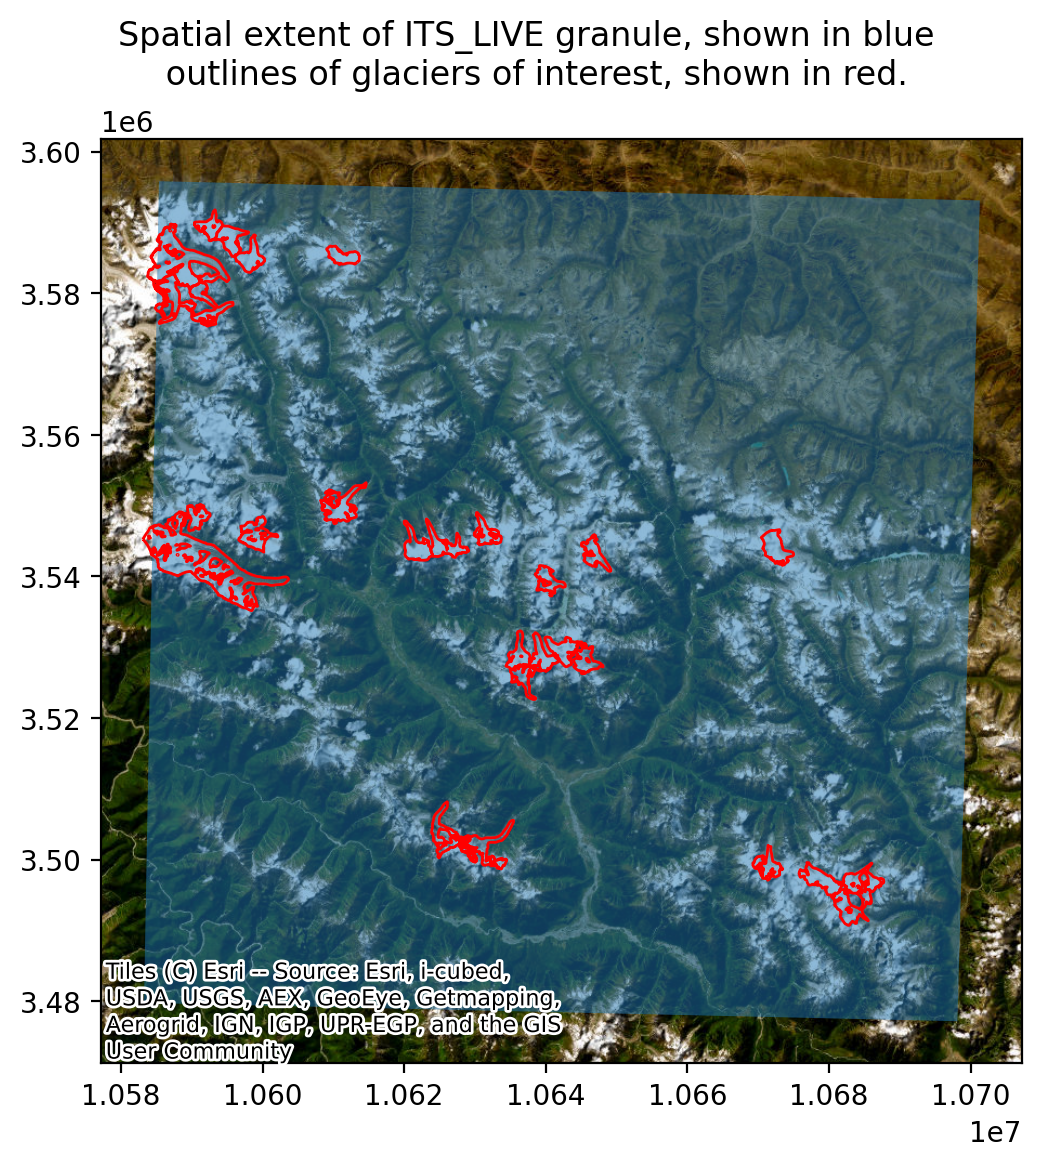

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
dc_bbox.to_crs('EPSG:3857').plot(ax=ax, alpha=0.5)
rgi_subset.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='r')

cx.add_basemap(ax=ax, crs='EPSG:3857', 
               source=cx.providers.Esri.WorldImagery,)
fig.suptitle('Spatial extent of ITS_LIVE granule, shown in blue \n outlines of glaciers of interest, shown in red.');

Instead, we use the [`Xvec.zonal_stats()`](https://xvec.readthedocs.io/en/stable/zonal_stats.html) method to convert the 3-dimensional cube to a 2-dimensional cube that has  time dimesnion and a geometry dimension. Each element of the geometry dimension is a glacier from the `rgi_subset` dataframe.

```{note} 
Because we are working with polygon geometries, we use zonal_stats() which performs a reduction over the area of the polygon. If our vector data was made up of point features, we could use [`Xvec.extract_points()`](https://xvec.readthedocs.io/en/stable/extract_pts.html)
```

### {{b1_its_nb4}}

In [18]:
dask.config.set({"array.slicing.split_large_chunks": True})
vector_data_cube = dc_resamp.xvec.zonal_stats(rgi_subset.geometry,
                                       x_coords='x', y_coords='y',
).drop_vars('index')

In [19]:
vector_data_cube

<xarray.Dataset> Size: 898kB
Dimensions:                     (geometry: 28, mid_date: 154)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1kB 1986-09-30 ... ...
  * geometry                    (geometry) object 224B POLYGON Z ((698995.534...
Data variables: (12/48)
    M11                         (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    M12                         (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    chip_size_height            (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    chip_size_width             (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    interp_mask                 (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    v                           (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_error_slow               (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_error_stationary         (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift             (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift_slow        (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift_stationary  (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:32646)
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Great, now we've gone from a 3-d object with (mid_date,x,y) dimensions to a 2-d object with (mid_date, geometry) dimensions. However, in addition to the geometry data stored in the vector dataframe, we'd also like to add some of the attribute data to the ITS_LIVE time series vector cube. The following cell adds attributes as coordinate variables to the vector data cube.

### {{b2_its_nb4}}

In [20]:
#Define attributes to be added
rgi_attrs_dict = {'RGIId': 'rgi_id',
              'Area_km2': 'area_km2',
              'Slope_deg': 'slope_deg'}

def update_cube_attrs(ds, gdf, attrs_dict):
    for k, v in attrs_dict.items():
        ds[k] = (('geometry'), gdf[v].values)
        ds = ds.assign_coords({k: ds[k]})
    return ds

vector_data_cube = update_cube_attrs(vector_data_cube, rgi_subset, rgi_attrs_dict)

In [21]:
vector_data_cube 

<xarray.Dataset> Size: 899kB
Dimensions:                     (geometry: 28, mid_date: 154)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 1kB 1986-09-30 ... ...
  * geometry                    (geometry) object 224B POLYGON Z ((698995.534...
    RGIId                       (geometry) object 224B 'RGI2000-v7.0-G-15-116...
    Area_km2                    (geometry) float64 224B 60.49 5.03 ... 8.753
    Slope_deg                   (geometry) float64 224B 21.73 19.25 ... 17.63
Data variables: (12/48)
    M11                         (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    M12                         (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    chip_size_height            (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    chip_size_width             (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    interp_mask                 (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    v                           (geometry, mid_date) float32 17kB dask.array<chunksize=(1, 148), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_error_slow               (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_error_stationary         (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift             (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift_slow        (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
    vy_stable_shift_stationary  (geometry, mid_date) float32 17kB dask.array<chunksize=(28, 148), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:32646)
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### {{b3_its_nb4}}

Later in this notebook, we will want to perform operations that require this object to be loaded into memory. All of our steps thus far have happened lazily, and when we do load the data into memory it will be quite time-consuming. 

To skip this step, I've loaded the data into memory and written it to disk. This allows us to read the vector data cube (which is much more manageable) into memory from file. 

Because this step is quite computationally intensive, I won't execute it here, but I will include the code for the sake of completeness. 

#### Steps to write vector data cube to disk
1. Encode vector data code geometries as [CF] geometries. 
This is required because Shapely geometries (how geometries are represented in memory) are not compatible with array-based file formats such as Zarr. To get around this, Xvec uses a package called cf-xarray to encode the Shapely geometries as CF geometries. For more detail on reading and writing vector data cubes, see the Xvec [documentation](https://xvec.readthedocs.io/en/stable/io.html).

    ```python
    encoded_vdc = vector_data_cube.xvec.encode_cf()
    ```

2. Write encoded data cube to Zarr (*This triggers `.compute()`, loading the data into memory before writing it to disk.* On my computer, this took about 12 minutes. 
    ```python
    with ProgressBar():

        encoded_vdc.to_zarr('data/regional_glacier_velocity_vector_cube.zarr', mode='w')
    ```
    Output:
    [########################################] | 100% Completed | 12m 15s

## C. Data visualization

### {{c1_its_nb4}}

The vector data cube is stored on disk with CF geometries. We go through the reverse of the process we used to write the object to disk, decoding the CF geometries to Shapely geometries with `xvec.decode_cf()`. 

In [22]:
vector_data_cube_cf = xr.open_zarr('../data/tutorial1/regional_glacier_velocity_vector_cube.zarr')
vector_data_cube = vector_data_cube_cf.xvec.decode_cf().compute()

### {{c2_its_nb4}}

Xvec has a method, `to_geodataframe()` that allows us to easily convert the `xr.Dataset` vector cube to a `gpd.GeoDataFrame`. We can then use the GeoPandas `.explore()` method to interactively visualize the data.

We will look at mean velocities over time.

In [23]:
vector_data_cube_mean = vector_data_cube.mean(dim='mid_date')

vector_data_cube_mean['vmag'] = np.sqrt(vector_data_cube_mean['vx']**2 + vector_data_cube_mean['vy']**2)

vector_data_cube_mean['vmag'].xvec.to_geodataframe(geometry='geometry').explore('vmag')

We could also look at single seasons:

In [24]:
vector_cube_seasonal_mean = vector_data_cube.groupby('mid_date.season').mean()

vector_cube_seasonal_mean['vmag'] = np.sqrt(vector_cube_seasonal_mean['vx']**2 + vector_cube_seasonal_mean['vy']**2)

vector_cube_seasonal_mean.sel(season='JJA')['vmag'].xvec.to_geodataframe(geometry='geometry').explore('vmag')

### {{c3_its_nb4}}

In addition to using GeoPandas plotting features, we can still use Xarray's built in plotting features to visualize the non-spatial elements of the data. Below, we visualize the relationships between magnitude of velocity (y-axis), glacier slope (x-axis) and glacier area (hue). 

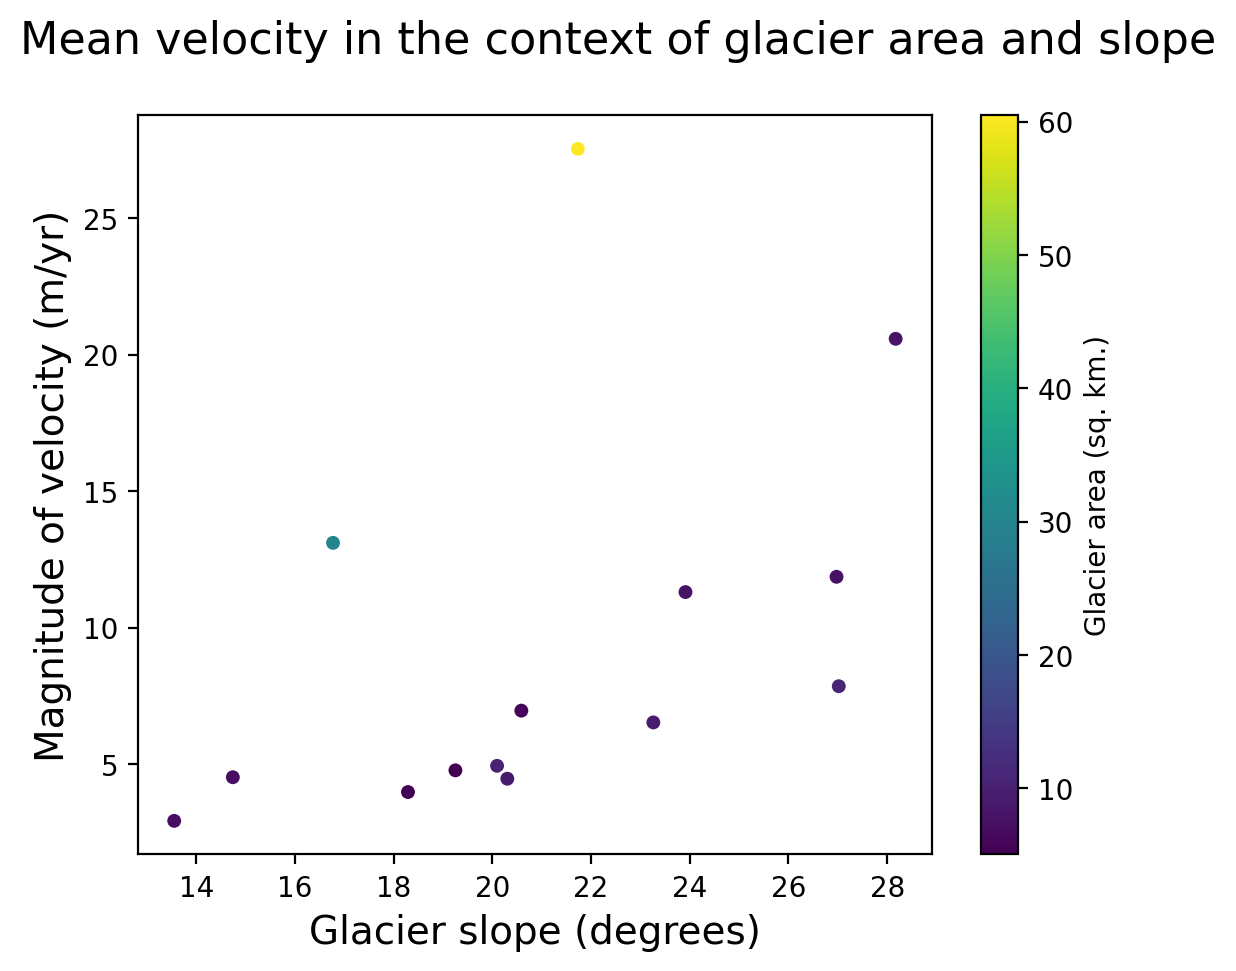

In [25]:
fig, ax = plt.subplots()

fig.suptitle('Mean velocity in the context of glacier area and slope', fontsize=16)

sc = vector_data_cube_mean.plot.scatter(
    x = 'Slope_deg', y='vmag', hue='Area_km2',
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'Glacier area (sq. km.)'})
ax.set_ylabel('Magnitude of velocity (m/yr)', fontsize=14)
ax.set_xlabel('Glacier slope (degrees)', fontsize=14);


In [ ]:
{{conclusion}}